Melbourne is the second largest city in Australia, and its metropolitan area alone is home to more than a million people. (...) In this article we want to take a closer look at how it is to live in central Melbourne by exploring the relationship between wealth, environmental conditions and access to services. Do the rich people in Melbourne have access to more services and a cleaner living environment? And does Melbournes residents care about living next to green spaces? Stay tuned to explore these questions in further detail with us.

We will be using three different public datasets to perform our analysis of Melbourne's living environment. The first one is a housing dataset, which contains records of houses sold in greater Melbourne over a span of XX years. By looking at house prices in different suburbs of Melbourne we can get an understanding of the wealth of the residents living there. The second dataset describes Melbourne's urban forest, by providing information about every tree's location, age and more. This dataset gives an indication about the amount of green spaces available in the city. The third and last dataset we will take a look at is an overview of different services in the city and their location. This dataset provides information about services like transportation, health, schools and recreation.

Let us first explore the data with some maps. Can we see some patterns between the location (and price) of houses and the proximity of green spaces and public services?

The following map shows an overview of houses sold in the city of Melbourne. We only want to investigate houses within the boundaries of the 14 main suburbs in the municipality of Melbourne, and the boundary is shown as a blue line here.
**Hover over a dot to see how much a house costs!**

In [1]:
# Relevant imports
import pandas as pd
import geopandas as gpd
import numpy as np
from shapely.geometry import Point
import folium
from folium import plugins
from folium.plugins import HeatMap
from folium import FeatureGroup
import ast
import haversine as hs
import matplotlib.pyplot as plt
from bokeh.models import ColumnDataSource
from bokeh.plotting import figure, show
from bokeh.io import output_notebook, show
output_notebook()

import seaborn as sns
from sklearn import model_selection
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error # for calculating the cost function
from collections import Counter
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix
from sklearn.tree import export_graphviz
from sklearn import tree

Loading BokehJS ...

In [2]:
# Load Melbourne trees dataset into pandas DataFrame
url = "https://data.melbourne.vic.gov.au/api/views/fp38-wiyy/rows.csv?accessType=DOWNLOAD"
trees_data = pd.read_csv(url)
trees_data["Date Planted"] = pd.to_datetime(trees_data["Date Planted"], format="%d/%m/%Y")
# print(trees_data.shape)
# trees_data.head()

In [3]:
# Load Melbourne house dataset into pandas DataFrame
cols = ["Suburb", "Address", "Rooms", "Type", "Price", "Method", "SellerG",
       "Date", "Distance", "Postcode", "Bedroom2", "Bathroom", "Car",
       "Landsize", "BuildingArea", "YearBuilt", "CouncilArea", "Latitude",
       "Longitude", "Regionname", "Propertycount", "Services_500m" , "Trees_500m"]
housing_data = pd.read_csv("housing_services_trees.csv", header=0, names=cols)
housing_data['Date'] = pd.to_datetime(housing_data['Date'])
houses_with_trees = housing_data

In [4]:
# Load Melbourne municipal boundary from shapefile (City of Melbourne Open Data)
municipal_boundary_url = "https://data.melbourne.vic.gov.au/api/geospatial/ck33-yh8z?method=export&format=Shapefile"
geoJSON_df = gpd.read_file(municipal_boundary_url)
[municipal_boundary] = gpd.GeoSeries(geoJSON_df.geometry)

In [5]:
# Filter houses to only those within the municipal boundary
in_municipality = housing_data[["Latitude", "Longitude"]].apply(lambda x: municipal_boundary.contains(Point((x.Longitude, x.Latitude))), axis=1)
filtered_houses = housing_data[in_municipality]

# Filter house dataset to include only those that have a price
pd.notna(filtered_houses.Price).value_counts()
has_price = pd.notna(filtered_houses.Price)
has_price = filtered_houses[has_price]
houses_with_price = has_price.reset_index(drop=True)

# houses_with_price

In [6]:
houses_concentration = [([x.Latitude, x.Longitude], x.Price) for x in houses_with_price.itertuples()]
mapM = folium.Map([-37.81, 144.94], zoom_start=13)
folium.GeoJson(municipal_boundary).add_to(mapM)
for (loc, price) in houses_concentration:
    circle = folium.Circle(location=loc, radius=18, color="#ff1427", fill_color="#ff1427", fill_opacity=1, tooltip=f"Price: {price:.0f} AUD").add_to(mapM)
mapM

Let's see how prices compare across these neighborhoods! The industrial areas near the ports don't seem to have many house sales in the last few years, which makes sense but makes those regions less interesting to explore. Let's compare prices across the neighborhoods:

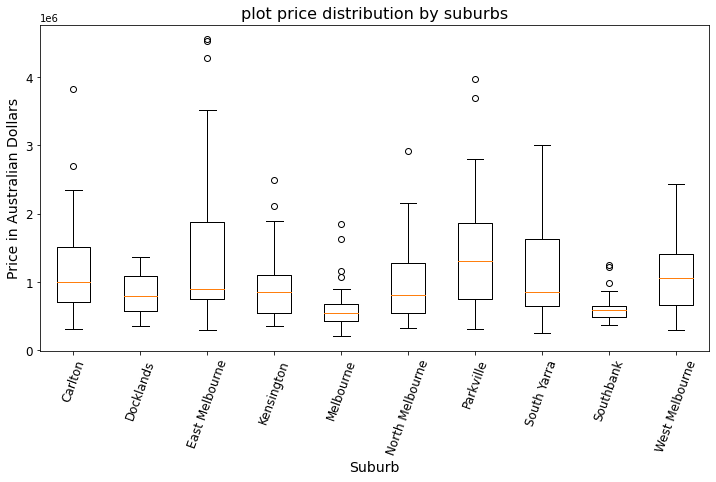

In [7]:
suburbs = sorted(houses_with_trees.Suburb.unique())
box_data = [houses_with_trees[houses_with_trees.Suburb == s].Price for s in suburbs]
#Boxplotting
fig, ax = plt.subplots(figsize=(12, 6))
plt.yticks(fontsize=12)
ax.set_title("plot price distribution by suburbs", fontsize=16)
ax.boxplot(box_data)
ax.set_xticklabels(suburbs, rotation=70, fontsize=12)
ax.set_ylabel("Price in Australian Dollars", fontsize=14)
ax.set_xlabel("Suburb",fontsize=14)
plt.show()

OK, this helps us identify wealthier neighborhoods. Areas near the Central Business District seem to trend higher. What about different types of homes?

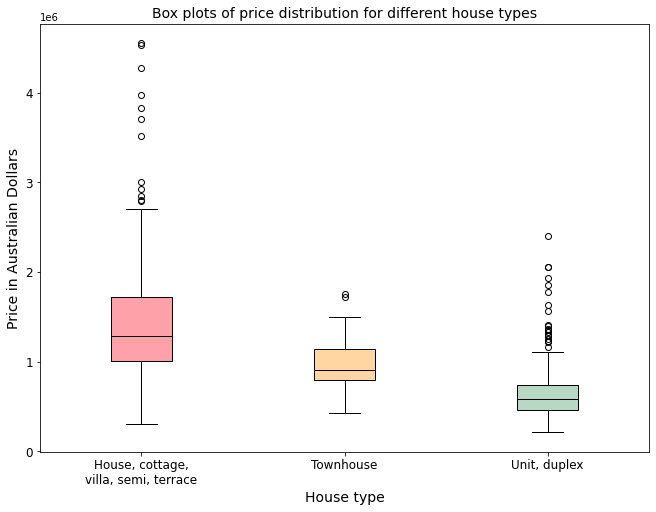

In [8]:
houses_with_trees = housing_data
suburbs = sorted(houses_with_trees.Suburb.unique())
types = sorted(houses_with_trees.Type.unique())
type_labels = {'u': 'Unit, duplex', 'h': 'House, cottage,\nvilla, semi, terrace', 't': 'Townhouse'}
box_data = np.array([np.asarray(houses_with_trees[houses_with_trees.Type == t].Price) for t in types], dtype=object)
xtick_labels = [type_labels[t] for t in types]
colors = ["#FF1427", "#FF9914", "#4C9F70"]

fig, ax = plt.subplots(1, 1, figsize=(9, 7), constrained_layout=True)
#Displaying box plots
boxplots = ax.boxplot(box_data, patch_artist=True)
ax.set_xticklabels(xtick_labels)
ax.set_title('Box plots of price distribution for different house types',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax.set_ylabel("Price in Australian Dollars", fontsize=14)
ax.set_xlabel("House type",fontsize=14)
#Color code boxes according to types
for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(boxplots[element], color="black")
for (patch, color) in zip(boxplots["boxes"], [f"{c}66" for c in colors]):
  patch.set_facecolor(color)

# #Displaying violin plots
# violinplots = ax[1].violinplot(box_data, showmedians=True)
# ax[1].set_xticklabels(xtick_labels)
# ax[1].set_title('Violin plots of price distribution for different house types',fontsize=14)
# ax[1].set_ylabel("Price in Australian Dollars", fontsize=14)
# ax[1].set_xlabel("House type",fontsize=14)
# plt.xticks(fontsize=12)
# plt.yticks(fontsize=12)

#Color violin plots according to types
# for element in ['bodies', 'cbars', 'cmaxes', 'cmedians', 'cmins']:
#         plt.setp(violinplots[element], color="black")
# for (pc, color) in zip(violinplots['bodies'], [f"{c}66" for c in colors]):
#     pc.set_facecolor(color)

plt.show()

Pretty wide spreads for all of them, but single family homes trending higher. Makes sense so far!

We don't want to be naive and assume all of our data is perfect. Let's take a look at the 'Distance' property provided by our dataset. Experiment with the toggles and see if you can find anything weird. 

In [9]:
# Check distance for errors
dist_groups = sorted(houses_with_trees.Distance.value_counts().index)
# Define colors for different distance groups
colors = ["black", "darkred", "#E600E5", "#E6C458", "#E6006F", "#0A78E6", "lightblue", "#17FFE6", "red", "orange", "#E6C5FF", "#8BE609", "cadetblue", "#609F60", "#9E7A59", "lightgreen"]
mapM = folium.Map([-37.81, 144.94], zoom_start=13, tiles="cartodbpositron")
# Add distance groups to separate layers on map
for idx, d in enumerate(dist_groups):
    feature_group = FeatureGroup(name=f"{dist_groups[idx]}km")
    house_group = houses_with_trees[houses_with_trees["Distance"] == d]
    house_locs= [([x.Latitude, x.Longitude], x.Price) for x in house_group.itertuples()]
    for (loc, p) in house_locs:
      popup = folium.Popup(f"Price: {p}")
      circle = folium.Circle(location=loc, radius=30, color="colors[idx]", fill_color=colors[idx], fill_opacity=1).add_child(popup)
      feature_group.add_child(circle)
    mapM.add_child(feature_group)
mapM.add_child(folium.map.LayerControl(collapsed=False))
mapM

You probably noticed that entire neighborhoods have the exact same distance value! Neighborhoods can be pretty widespread, so assigning a uniform value with potential error of ~50% isn't super helpful. Even worse, you may have noticed that houses in central Melbourne fall under both the 0km and 2.8km marker. Clearly this feature is unreliable! We won't be using the distance property.

In [11]:
# Download and preprocess spatial data (districts/suburbs of Melbourne)
districts_url = "https://data.melbourne.vic.gov.au/api/geospatial/m7yp-p495?method=export&format=Shapefile"
district_names = ["Flemington", "Port Melbourne", "North Melbourne", "West Melbourne", "South Yarra",
                  "Royal Melbourne Hospital", "Carlton", "World Trade Centre", "Southbank", "3054", 
                  "Parkville", "3004", "East Melbourne", "Docklands", "Melbourne", "University Of Melbourne", "Kensington"]

geoJSON_df = gpd.read_file(districts_url)
geoJSON_df["district"] = district_names
district_boundaries = geoJSON_df.drop(["mccid_gis", "maplabel", "name", "xorg", "mccid_str", "xsource", "xdate", "mccid_int"], axis=1)
district_shapes = gpd.GeoSeries(district_boundaries.geometry)

# Compute number of trees in each district
district_data = []
for idx, s in enumerate(district_shapes):
    in_district = trees_data[["Latitude", "Longitude"]].apply(lambda x: s.contains(Point((x.Longitude, x.Latitude))), axis=1)
    district_trees = len(trees_data[in_district])
    district_name = district_names[idx]
    district_data.append([district_name, district_trees])
district_trees_df = pd.DataFrame(district_data, columns=["district", "trees"])
# Format suburb shape, name and tree count for plotting
district_trees_geo = district_boundaries.merge(district_trees_df, on="district")
district_trees_geo.head()

mapM = folium.Map([-37.81, 144.94], zoom_start=13)
feature_group = FeatureGroup(name=f"Houses in Melbourne")
# Display interactive Choropleth map of district tree counts
folium.Choropleth(
    geo_data=district_trees_geo,
    data=district_trees_geo,
    columns=["district", "trees"],
    key_on="feature.properties.district",
    fill_color="YlGn",
    fill_opacity=.8,
    line_opacity=1,
    legend_name="Number of trees",
    smooth_factor=0,
    Highlight= True,
    line_color = "#0000",
    name = "Number of trees in district",
    overlay=True,
).add_to(mapM)

# Mark house sales locations on map
house_locs= [[x.Latitude, x.Longitude] for x in houses_with_trees.itertuples()]
for loc in house_locs:
    feature_group.add_child(folium.Circle(location=loc, radius=3, color="black", fill_color="black", fill_opacity=1))
mapM.add_child(feature_group)

# Add hover functionality.
style_function = lambda x: {"fillColor": "#ffffff", 
                            "color":"#000000", 
                            "fillOpacity": 0.1, 
                            "weight": 0.1}
highlight_function = lambda x: {"fillColor": "#000000", 
                                "color":"#000000", 
                                "fillOpacity": 0.50, 
                                "weight": 0.1}
hover = folium.features.GeoJson(
    data = district_trees_geo,
    style_function=style_function, 
    control=False,
    highlight_function=highlight_function, 
    tooltip=folium.features.GeoJsonTooltip(
        fields=["district", "trees"],
        aliases=["district", "trees"],
        style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;") 
    )
)
mapM.add_child(hover)
mapM.keep_in_front(hover)

# Add dark and light mode. 
folium.TileLayer("cartodbdark_matter",name="dark mode",control=True).add_to(mapM)
folium.TileLayer("cartodbpositron",name="light mode",control=True).add_to(mapM)

# Add a layer controller. 
folium.LayerControl(collapsed=False).add_to(mapM)
mapM